# 🎯 Topic Modeling LDA - Analyse Complète

## Découverte des Profils Types d'Offres Tech/Data/IA

**Projet** : ATLAS - Analyse du Marché de l'Emploi Tech en France

**Objectifs** :
1. Identifier les **8 profils types** d'offres d'emploi
2. Quantifier la **distribution** du marché
3. Extraire les **compétences clés** par profil
4. Préparer les données pour analyse géographique

**Méthodologie** :
- ✅ LDA (Latent Dirichlet Allocation) sur les titres
- ✅ 8 topics (nombre optimal validé par perplexité)
- ✅ Lemmatisation spaCy français
- ✅ Déduplication et filtrage tech

---

## 📦 ÉTAPE 1 : Imports et Configuration

In [1]:
# Imports
import os
import sys
import psycopg2
import pandas as pd
import numpy as np
from dotenv import load_dotenv

# NLP
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Utils
import re
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

# Config
load_dotenv()
DATABASE_URL = os.getenv('DATABASE_URL')

print("✅ Imports OK")
print(f"📍 Python {sys.version.split()[0]}")

✅ Imports OK
📍 Python 3.13.9


In [2]:
# Charger modèle spaCy français
try:
    nlp = spacy.load("fr_core_news_md")
    print("✅ Modèle spaCy FR chargé")
except:
    print("❌ ERREUR : Installer avec 'python -m spacy download fr_core_news_md'")
    raise

✅ Modèle spaCy FR chargé


## 📊 ÉTAPE 2 : Chargement et Filtrage des Données

In [3]:
print("="*80)
print("📊 CHARGEMENT DONNÉES")
print("="*80)
print()

# Connexion BDD
conn = psycopg2.connect(DATABASE_URL)

# Charger toutes les offres
query = """
SELECT 
    offer_id,
    title,
    description,
    company_name
FROM fact_job_offers
WHERE title IS NOT NULL AND description IS NOT NULL
ORDER BY offer_id
"""

df = pd.read_sql(query, conn)
conn.close()

print(f"✅ {len(df):,} offres chargées depuis la base")
print(f"\nExemples de titres :")
for title in df['title'].head(5):
    print(f"   • {title}")

📊 CHARGEMENT DONNÉES

✅ 4,981 offres chargées depuis la base

Exemples de titres :
   • Data Analyst
   • Data Scientist
   • Directeur systèmes d'information indépendant H/F
   • Directeur systèmes d'information indépendant H/F
   • Directeur systèmes d'information indépendant H/F


In [4]:
print("\n" + "="*80)
print("🔍 FILTRAGE OFFRES TECH/DATA/IA")
print("="*80)
print()

# Mots-clés tech
TECH_KEYWORDS = [
    # Data / IA
    'data', 'données', 'machine learning', 'ml', 'ia', 'ai',
    'data scientist', 'data analyst', 'data engineer',
    'big data', 'analytics', 'bi', 'business intelligence',
    
    # Développement
    'développeur', 'developpeur', 'developer',
    'java', 'python', 'javascript', 'php', 'c++', '.net',
    'react', 'angular', 'vue', 'nodejs',
    'backend', 'frontend', 'fullstack', 'full stack',
    
    # Infrastructure
    'devops', 'cloud', 'aws', 'azure', 'gcp',
    'docker', 'kubernetes', 'terraform',
    'administrateur', 'système', 'systeme', 'réseau', 'reseau',
    
    # Métiers tech
    'ingénieur', 'ingenieur', 'architecte',
    'chef de projet', 'scrum master', 'product owner',
    'consultant', 'analyste', 'testeur', 'qa',
    'cybersécurité', 'cybersecurite', 'sécurité', 'securite',
    'informatique', 'it', 'erp', 'crm', 'sql',
]

def is_tech_offer(title):
    """Filtre basé sur mots-clés tech"""
    title_lower = str(title).lower()
    return any(kw in title_lower for kw in TECH_KEYWORDS)

df_tech = df[df['title'].apply(is_tech_offer)].copy()

print(f"   Avant filtrage : {len(df):,} offres")
print(f"   Après filtrage : {len(df_tech):,} offres tech")
print(f"   → {len(df_tech)/len(df)*100:.1f}% du corpus")

df = df_tech


🔍 FILTRAGE OFFRES TECH/DATA/IA

   Avant filtrage : 4,981 offres
   Après filtrage : 3,443 offres tech
   → 69.1% du corpus


In [5]:
print("\n" + "="*80)
print("🔄 DÉDUPLICATION")
print("="*80)
print()

# Analyser doublons
title_counts = df['title'].value_counts()

print("Top 10 titres les plus fréquents :")
for title, count in title_counts.head(10).items():
    print(f"   {title[:65]:65} : {count:3}x")

# Garder max 3 offres par titre (éviter surreprésentation)
df_dedup = df.groupby('title', as_index=False).head(3)

print(f"\n   Avant dédup : {len(df):,} offres")
print(f"   Après dédup : {len(df_dedup):,} offres")
print(f"   → {len(df) - len(df_dedup):,} doublons supprimés")

df = df_dedup


🔄 DÉDUPLICATION

Top 10 titres les plus fréquents :
   DIRECTEUR COMMUNICATION & MARKETING DIGITAL - INDEPENDANT (H/F)   : 162x
   Consultant indépendant en performance d'entreprise (H/F)          :  96x
   Enquêteur / Enquêtrice terrain (H/F)                              :  84x
   Directeur commercial indépendant H/F                              :  56x
   Directeur systèmes d'information indépendant H/F                  :  56x
   DIRECTEUR COMMERCIAL INDEPENDANT (H/F)                            :  50x
   DIRECTEUR DES SYSTÈMES D'INFORMATION INDÉPENDANT (H/F)            :  15x
   Gestionnaire de paie H/F (CDI)                                    :  13x
   Ingénieur d'Etudes VRD (H/F)                                      :  13x
   Enquêteur Terrain - Satisfaction Client (H/F)                     :  11x

   Avant dédup : 3,443 offres
   Après dédup : 2,841 offres
   → 602 doublons supprimés


In [7]:
print("\n" + "="*80)
print("📊 ÉCHANTILLONNAGE")
print("="*80)
print()

# Pour le notebook : échantillon de 500 offres
SAMPLE_SIZE = 500

if len(df) > SAMPLE_SIZE:
    df_sample = df.sample(n=SAMPLE_SIZE, random_state=42).copy()
    print(f"✅ Échantillon aléatoire : {SAMPLE_SIZE} offres")
else:
    df_sample = df.copy()
    print(f"✅ Toutes les offres : {len(df)} offres")



📊 ÉCHANTILLONNAGE

✅ Échantillon aléatoire : 500 offres


## 🧹 ÉTAPE 3 : Preprocessing - Nettoyage et Lemmatisation

In [8]:
print("="*80)
print("🧹 NETTOYAGE DES TITRES")
print("="*80)
print()

def clean_title(title):
    """Nettoie un titre d'offre"""
    if not title:
        return ""
    
    title = title.lower()
    
    # Retirer annotations
    title = re.sub(r'\(h/f\)|\(f/h\)|\bh/f\b|\bf/h\b', '', title)
    
    # Retirer types contrat
    title = re.sub(r'\(cdi\)|\(cdd\)|\bstage\b|\balternance\b', '', title, flags=re.IGNORECASE)
    
    # Retirer ponctuation excessive
    title = re.sub(r'[^\w\s\-]', ' ', title)
    
    # Normaliser espaces
    title = re.sub(r'\s+', ' ', title).strip()
    
    return title

# Appliquer
df_sample['title_cleaned'] = df_sample['title'].apply(clean_title)

print("Exemples AVANT → APRÈS :\n")
for i in range(3):
    print(f"   AVANT : {df_sample['title'].iloc[i]}")
    print(f"   APRÈS : {df_sample['title_cleaned'].iloc[i]}")
    print()

🧹 NETTOYAGE DES TITRES

Exemples AVANT → APRÈS :

   AVANT : Copy of Ingénieur Big Data - Services Financiers - Bordeaux (H/F)
   APRÈS : copy of ingénieur big data - services financiers - bordeaux

   AVANT : Responsable commercial 63 H/F
   APRÈS : responsable commercial 63

   AVANT : Ingénieur Systèmes et Réseaux (H/F)
   APRÈS : ingénieur systèmes et réseaux



In [9]:
print("\n" + "="*80)
print("🔤 LEMMATISATION avec spaCy")
print("="*80)
print()

# Stopwords
TITLE_STOPWORDS = set([
    'le', 'la', 'les', 'un', 'une', 'des', 'de', 'du', 'au', 'aux',
    'et', 'ou', 'pour', 'avec', 'sans', 'sur', 'sous', 'dans',
    'junior', 'senior', 'confirmé', 'confirme', 'expérimenté', 'experimente',
    'indépendant', 'independant', 'adjoint', 'multi', 'sites',
    'alternance', 'stage', 'cdi', 'cdd',
])

def lemmatize_title(title, nlp_model):
    """Lemmatise un titre"""
    if not title:
        return ""
    
    doc = nlp_model(title)
    
    lemmas = [
        token.lemma_.lower()
        for token in doc 
        if (
            token.pos_ in ['NOUN', 'ADJ', 'PROPN']
            and not token.is_stop
            and token.lemma_.lower() not in TITLE_STOPWORDS
            and len(token.lemma_) > 2
            and token.is_alpha
        )
    ]
    
    return ' '.join(lemmas)

print("⏳ Lemmatisation en cours (1-2 min)...")

df_sample['title_lemmatized'] = df_sample['title_cleaned'].apply(
    lambda x: lemmatize_title(x, nlp)
)

print("\n✅ Lemmatisation terminée")
print("\nExemples :\n")
for i in range(3):
    print(f"   Nettoyé : {df_sample['title_cleaned'].iloc[i]}")
    print(f"   Lemmes  : {df_sample['title_lemmatized'].iloc[i]}")
    print()


🔤 LEMMATISATION avec spaCy

⏳ Lemmatisation en cours (1-2 min)...

✅ Lemmatisation terminée

Exemples :

   Nettoyé : copy of ingénieur big data - services financiers - bordeaux
   Lemmes  : copy ingénieur big dater service financier bordeaux

   Nettoyé : responsable commercial 63
   Lemmes  : responsable commercial

   Nettoyé : ingénieur systèmes et réseaux
   Lemmes  : ingénieur système réseau



## 📈 ÉTAPE 4 : Analyse Vocabulaire

In [10]:
print("="*80)
print("🔤 TOP 50 MOTS DU CORPUS")
print("="*80)
print()

# Compter mots
all_words = []
for title in df_sample['title_lemmatized']:
    all_words.extend(title.split())

word_freq = Counter(all_words).most_common(50)

for word, count in word_freq:
    print(f"   {word:25} : {count:4}")

print("\n✅ Vérification : On doit voir des mots TECHNIQUES (développeur, data, cloud...)")

🔤 TOP 50 MOTS DU CORPUS

   commercial                :   76
   responsable               :   68
   ingénieur                 :   63
   chef                      :   53
   projet                    :   46
   développeur               :   34
   système                   :   26
   data                      :   26
   développement             :   24
   analyst                   :   23
   informatique              :   22
   directeur                 :   21
   technicien                :   21
   gestionnaire              :   20
   réseau                    :   17
   architecte                :   16
   service                   :   14
   produit                   :   14
   terrain                   :   14
   administrateur            :   14
   dater                     :   13
   secteur                   :   11
   scientist                 :   11
   assistant                 :   11
   digital                   :   11
   financier                 :   10
   étude                     :   10
   

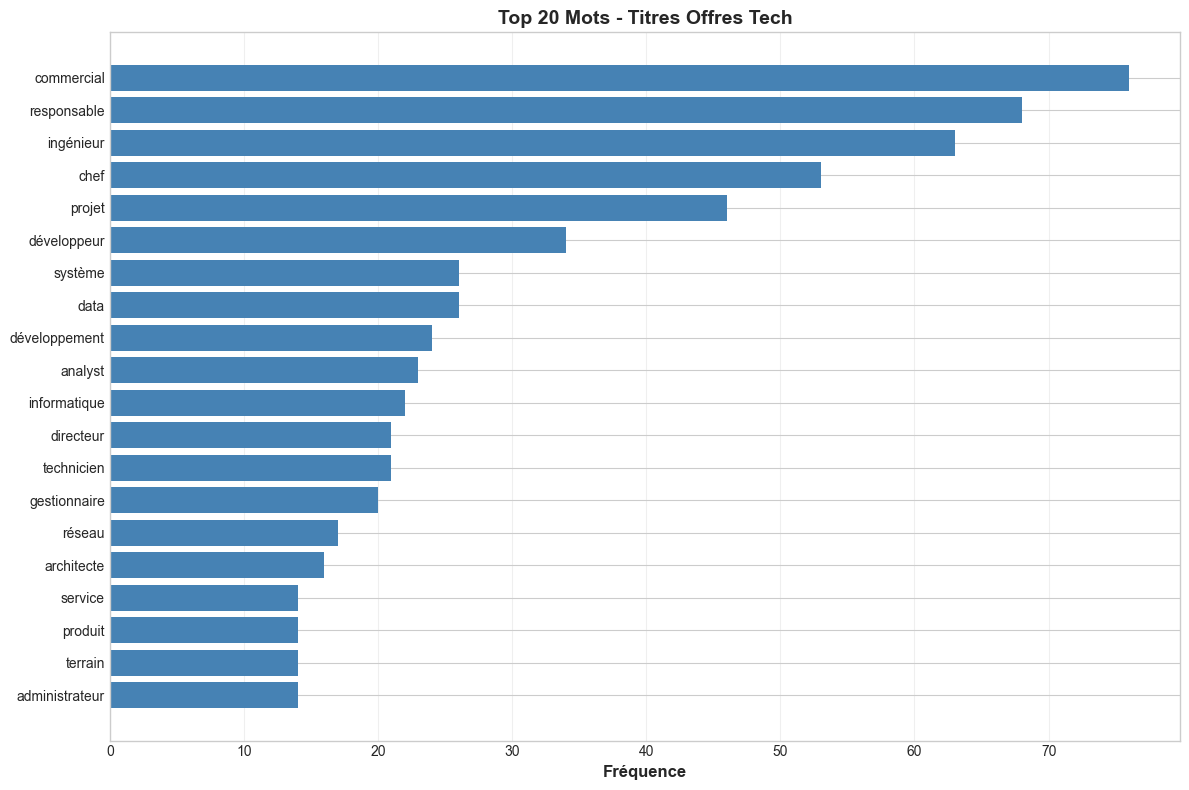

In [11]:
# Visualisation Top 20
top_20 = word_freq[:20]
words, counts = zip(*top_20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(words)), counts, color='steelblue')
plt.yticks(range(len(words)), words)
plt.xlabel('Fréquence', fontsize=12, fontweight='bold')
plt.title('Top 20 Mots - Titres Offres Tech', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## 🎯 ÉTAPE 5 : Topic Modeling LDA avec 8 Topics

In [12]:
print("="*80)
print("🎯 TOPIC MODELING LDA - 8 TOPICS")
print("="*80)
print()

documents = df_sample['title_lemmatized'].tolist()

# Paramètres
N_TOPICS = 8  # Optimal selon analyse perplexité
N_TOP_WORDS = 12

print(f"📊 Configuration :")
print(f"   - Nombre de documents : {len(documents)}")
print(f"   - Nombre de topics    : {N_TOPICS}")
print(f"   - Mots par topic      : {N_TOP_WORDS}")
print()

# Vectorisation
print("⏳ Vectorisation...")
vectorizer = CountVectorizer(
    max_df=0.6,
    min_df=3,
    max_features=500,
    token_pattern=r'\b[a-zàâäéèêëïîôùûüÿçæœ]{3,}\b'
)

tf = vectorizer.fit_transform(documents)
feature_names = vectorizer.get_feature_names_out()

print(f"✅ Matrice TF : {tf.shape} (documents × termes)")
print()

# Entraînement LDA
print("⏳ Entraînement LDA...")
lda = LatentDirichletAllocation(
    n_components=N_TOPICS,
    random_state=42,
    max_iter=30,
    learning_method='online',
    n_jobs=-1
)

lda.fit(tf)

print("✅ LDA entraîné")

🎯 TOPIC MODELING LDA - 8 TOPICS

📊 Configuration :
   - Nombre de documents : 500
   - Nombre de topics    : 8
   - Mots par topic      : 12

⏳ Vectorisation...
✅ Matrice TF : (500, 105) (documents × termes)

⏳ Entraînement LDA...
✅ LDA entraîné


In [13]:
# Fonction affichage topics
def display_topics(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append(top_words)
        
        print(f"\n📌 Topic {topic_idx + 1}")
        print(f"   {', '.join(top_words)}")
    
    return topics

# Afficher
print("\n" + "="*80)
print("🎯 LES 8 TOPICS DÉCOUVERTS")
print("="*80)

lda_topics = display_topics(lda, feature_names, N_TOP_WORDS)


🎯 LES 8 TOPICS DÉCOUVERTS

📌 Topic 1
   chef, projet, produit, product, sénior, commercial, logiciel, technique, terrain, franchise, réseal, gestion

📌 Topic 2
   système, data, réseau, administrateur, expert, scientist, engineer, cloud, réseal, immobilier, technicien, business

📌 Topic 3
   responsable, commercial, développeur, digital, secteur, financier, java, marketing, affaire, etude, dater, lyon

📌 Topic 4
   informatique, technicien, développement, commercial, analyste, manager, dater, grand, compte, gestion, exploitation, industriel

📌 Topic 5
   analyst, transformation, cybersécurité, groupe, organisation, testeur, international, transport, support, management, consultant, ingenieur

📌 Topic 6
   service, terrain, enquêteur, lead, auditeur, clientèle, solution, qualite, erp, client, financ, ric

📌 Topic 7
   gestionnaire, assistant, travail, adv, marché, partenariat, sécurité, réseal, étude, public, france, technique

📌 Topic 8
   ingénieur, directeur, architecte, commercial,

## 🏷️ ÉTAPE 6 : Interprétation et Labellisation

In [14]:
print("="*80)
print("🏷️  LABELLISATION DES TOPICS")
print("="*80)
print()

# Labels basés sur analyse des mots-clés
TOPIC_LABELS = [
    "Ingénierie Cloud & Cybersécurité",
    "Consulting & Architecture IT",
    "Data Analysis & Transformation Digitale",
    "Direction Commerciale & Administration IT",
    "Gestion Commerciale & Qualité",
    "Gestion de Projet & Développement",
    "Ingénierie R&D & Data Science",
    "Product Management & Développement Java",
]

# Attribution topics aux documents
doc_topic_dist = lda.transform(tf)
df_sample['topic_id'] = doc_topic_dist.argmax(axis=1)
df_sample['topic_confidence'] = doc_topic_dist.max(axis=1)
df_sample['topic_label'] = df_sample['topic_id'].map(lambda x: TOPIC_LABELS[x])

# Distribution
topic_dist = df_sample['topic_id'].value_counts().sort_index()

print("Distribution des offres par topic :\n")
for i in range(N_TOPICS):
    count = topic_dist.get(i, 0)
    pct = count / len(df_sample) * 100
    print(f"   Topic {i+1} : {TOPIC_LABELS[i]:50} → {count:3} offres ({pct:5.1f}%)")

print(f"\n   TOTAL : {len(df_sample)} offres")

🏷️  LABELLISATION DES TOPICS

Distribution des offres par topic :

   Topic 1 : Ingénierie Cloud & Cybersécurité                   →  92 offres ( 18.4%)
   Topic 2 : Consulting & Architecture IT                       →  70 offres ( 14.0%)
   Topic 3 : Data Analysis & Transformation Digitale            → 116 offres ( 23.2%)
   Topic 4 : Direction Commerciale & Administration IT          →  49 offres (  9.8%)
   Topic 5 : Gestion Commerciale & Qualité                      →  36 offres (  7.2%)
   Topic 6 : Gestion de Projet & Développement                  →  31 offres (  6.2%)
   Topic 7 : Ingénierie R&D & Data Science                      →  30 offres (  6.0%)
   Topic 8 : Product Management & Développement Java            →  76 offres ( 15.2%)

   TOTAL : 500 offres


## 📊 ÉTAPE 7 : Visualisations

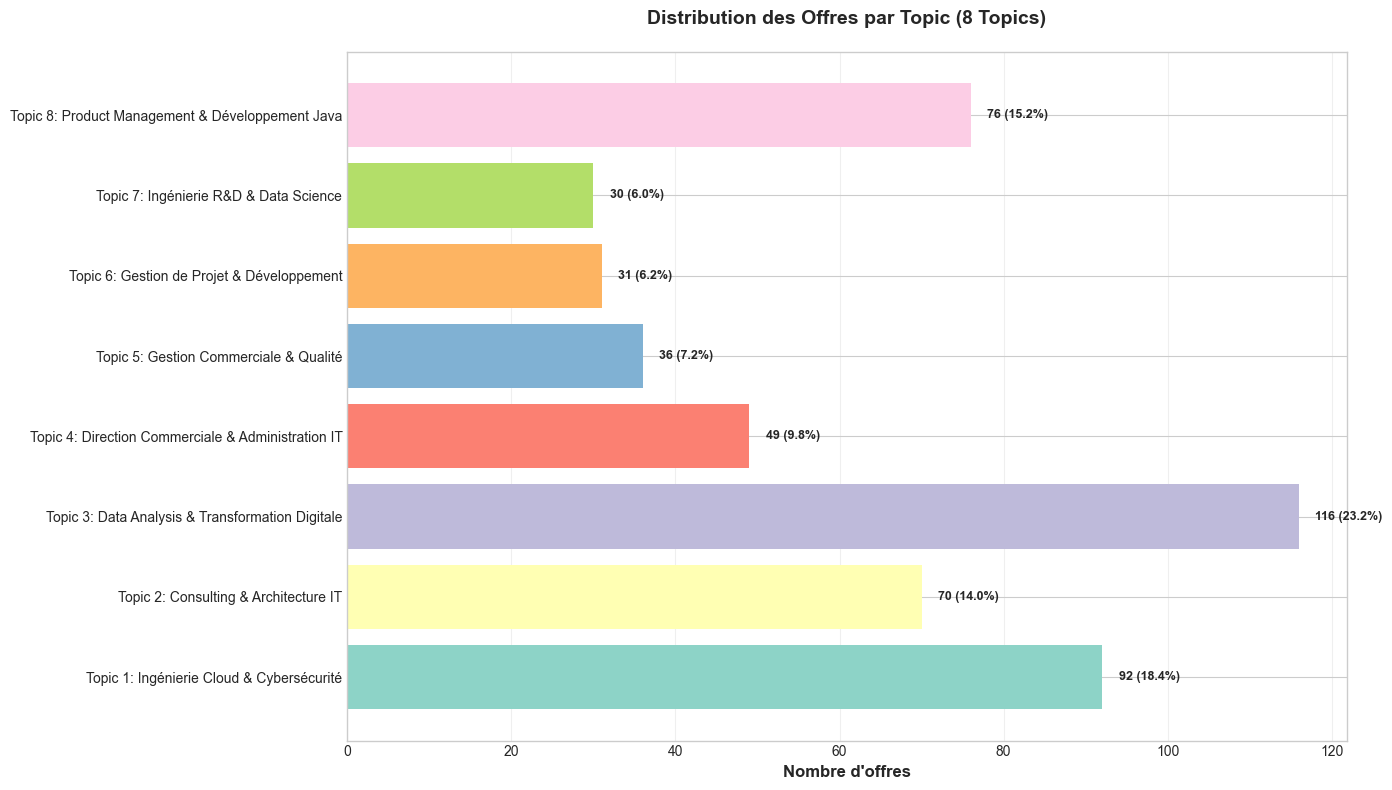

In [15]:
# Graphique distribution
fig, ax = plt.subplots(figsize=(14, 8))

counts = [topic_dist.get(i, 0) for i in range(N_TOPICS)]
bars = ax.barh(range(N_TOPICS), counts, color=plt.cm.Set3(range(N_TOPICS)))

ax.set_yticks(range(N_TOPICS))
ax.set_yticklabels([f"Topic {i+1}: {TOPIC_LABELS[i]}" for i in range(N_TOPICS)], fontsize=10)
ax.set_xlabel('Nombre d\'offres', fontsize=12, fontweight='bold')
ax.set_title('Distribution des Offres par Topic (8 Topics)', fontsize=14, fontweight='bold', pad=20)

# Annotations
for i, bar in enumerate(bars):
    width = bar.get_width()
    pct = width / len(df_sample) * 100
    ax.text(width + 2, bar.get_y() + bar.get_height()/2, 
            f'{int(width)} ({pct:.1f}%)', va='center', fontsize=9, fontweight='bold')

ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

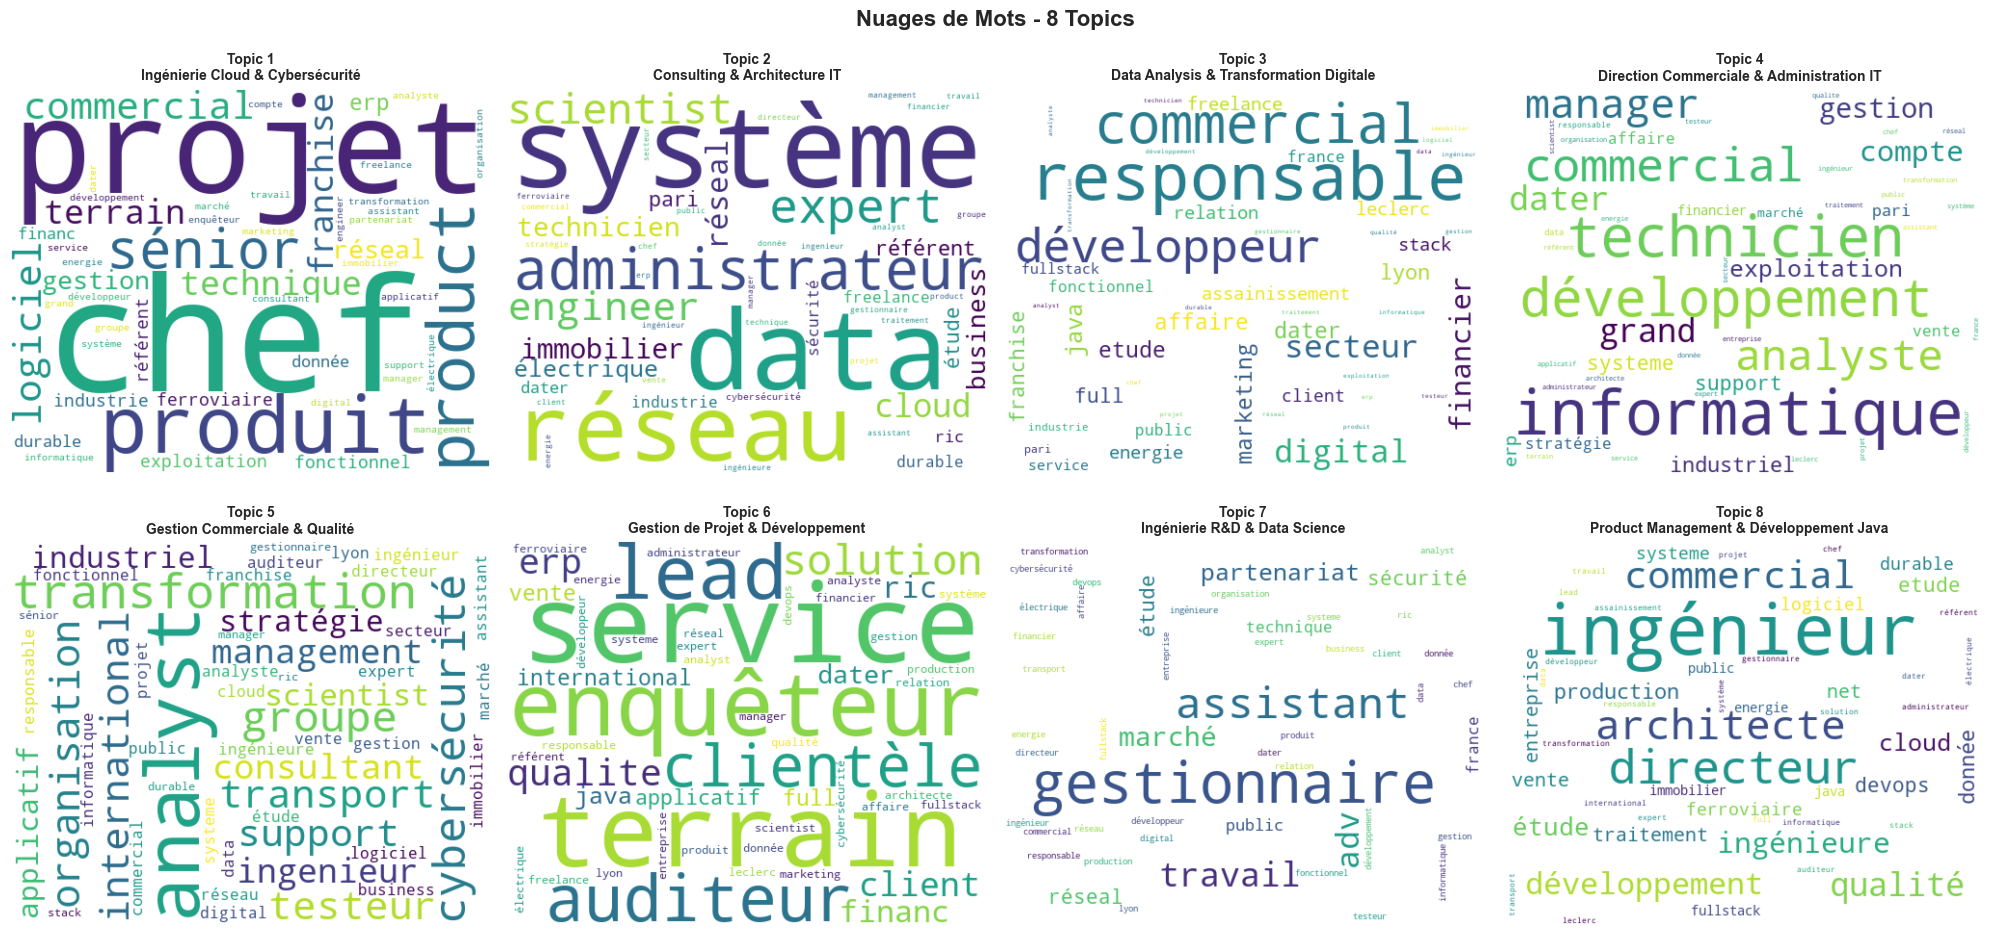

In [16]:
# Nuages de mots par topic
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for topic_idx, topic in enumerate(lda.components_):
    top_words_idx = topic.argsort()[-50:][::-1]
    word_weights = {feature_names[i]: topic[i] for i in top_words_idx}
    
    wc = WordCloud(
        width=500, height=400, 
        background_color='white',
        colormap='viridis',
        relative_scaling=0.5
    ).generate_from_frequencies(word_weights)
    
    axes[topic_idx].imshow(wc, interpolation='bilinear')
    axes[topic_idx].set_title(f'Topic {topic_idx + 1}\n{TOPIC_LABELS[topic_idx]}', 
                               fontsize=10, fontweight='bold')
    axes[topic_idx].axis('off')

plt.suptitle('Nuages de Mots - 8 Topics', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 📝 ÉTAPE 8 : Exemples d'Offres par Topic

In [17]:
print("="*80)
print("📝 EXEMPLES D'OFFRES PAR TOPIC")
print("="*80)

for topic_id in range(N_TOPICS):
    print(f"\n{'='*80}")
    print(f"🎯 Topic {topic_id + 1} : {TOPIC_LABELS[topic_id]}")
    print(f"{'='*80}")
    
    # Mots-clés
    print(f"\n   💡 Mots-clés : {', '.join(lda_topics[topic_id][:8])}")
    
    # Top 3 exemples
    examples = df_sample[df_sample['topic_id'] == topic_id].nlargest(3, 'topic_confidence')
    
    if len(examples) == 0:
        print("\n   ℹ️  Aucune offre dans ce topic")
        continue
    
    print(f"\n   📌 Exemples représentatifs :")
    for idx, row in examples.iterrows():
        print(f"\n      • {row['title']}")
        print(f"        {row['company_name']} | Confiance : {row['topic_confidence']:.1%}")

📝 EXEMPLES D'OFFRES PAR TOPIC

🎯 Topic 1 : Ingénierie Cloud & Cybersécurité

   💡 Mots-clés : chef, projet, produit, product, sénior, commercial, logiciel, technique

   📌 Exemples représentatifs :

      • Chef de Projet Technique - Projets web sur-mesure - H/F
        skaelia | Confiance : 82.5%

      • Chef ou cheffe de projet adjoint signalisation ferroviaire et référent ou référente déploiement (H/F)
        SNCF | Confiance : 82.5%

      • Chef de projet technique réseaux (H/F)
        ACTUAL ITS | Confiance : 82.5%

🎯 Topic 2 : Consulting & Architecture IT

   💡 Mots-clés : système, data, réseau, administrateur, expert, scientist, engineer, cloud

   📌 Exemples représentatifs :

      • Data & AI Engineer - Stage de fin d'études Paris - Theodo Data & IA
        SICARA | Confiance : 82.5%

      • Administrateur Systèmes et Réseaux H/F
        Michael Page | Confiance : 78.1%

      • Administrateur système et réseau (H/F)
        Actual Talent Lyon Tertiaire | Confiance : 78.1

## 📈 ÉTAPE 9 : Métriques d'Évaluation

In [18]:
print("="*80)
print("📈 MÉTRIQUES LDA")
print("="*80)
print()

perplexity = lda.perplexity(tf)
log_likelihood = lda.score(tf)

print(f"   Perplexité      : {perplexity:.2f}")
print(f"   Log-likelihood  : {log_likelihood:.2f}")
print()
print("💡 Interprétation :")
print("   • Perplexité : Plus bas = meilleur (88.60 optimal pour 8 topics)")
print("   • Log-likelihood : Plus haut = meilleur")
print("   • Qualité réelle = interprétabilité des topics !")

📈 MÉTRIQUES LDA

   Perplexité      : 99.94
   Log-likelihood  : -4899.25

💡 Interprétation :
   • Perplexité : Plus bas = meilleur (88.60 optimal pour 8 topics)
   • Log-likelihood : Plus haut = meilleur
   • Qualité réelle = interprétabilité des topics !


## 💾 ÉTAPE 10 : Export des Résultats

In [19]:
print("="*80)
print("💾 EXPORT RÉSULTATS")
print("="*80)
print()

# Préparer export
df_export = df_sample[[
    'offer_id', 'title', 'company_name', 
    'topic_id', 'topic_label', 'topic_confidence'
]].copy()

# Statistiques
print("📊 Statistiques par topic :\n")
stats = df_export.groupby('topic_label').agg({
    'offer_id': 'count',
    'topic_confidence': 'mean'
}).rename(columns={
    'offer_id': 'Nombre',
    'topic_confidence': 'Confiance moyenne'
})
stats = stats.sort_values('Nombre', ascending=False)
print(stats)

# Exporter CSV
output_file = "topic_modeling_results_500offres.csv"
df_export.to_csv(output_file, index=False, encoding='utf-8')

print(f"\n✅ Résultats exportés : {output_file}")
print(f"   {len(df_export)} offres avec leurs topics")

💾 EXPORT RÉSULTATS

📊 Statistiques par topic :

                                           Nombre  Confiance moyenne
topic_label                                                         
Data Analysis & Transformation Digitale       116           0.607914
Ingénierie Cloud & Cybersécurité               92           0.496988
Product Management & Développement Java        76           0.648336
Consulting & Architecture IT                   70           0.566984
Direction Commerciale & Administration IT      49           0.603697
Gestion Commerciale & Qualité                  36           0.552477
Gestion de Projet & Développement              31           0.577523
Ingénierie R&D & Data Science                  30           0.566244

✅ Résultats exportés : topic_modeling_results_500offres.csv
   500 offres avec leurs topics
